# FINAL RESULTS - WIDE & ROBUST BERT with SwiGLU and RMSnorm 
### 1/12/2026


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import spearmanr
import math
import warnings
import os

warnings.filterwarnings("ignore")

# ==========================================
# 1. OPTIMIZED CONFIGURATION (WIDE & ROBUST)
# ==========================================
CONFIG = {
    # --- ARCHITECTURE ---
    'model_type': 'BERT',
    'norm_type': 'RMSNorm',
    'use_qk_norm': True,
    'activation': 'swiglu',
    'use_bias': False,
    'deep_head': True,
    
    # --- DATA ---
    'keep_bacteria_only': True,
    'prevalence_threshold': 0.05,
    
    # --- TUNED PARAMETERS (The "Wide & Shallow" Strategy) ---
    'embed_dim': 384,        # Wider (was 192/256) -> Better representation
    'chunk_size': 750,       # Finer resolution (was 1000)
    'depth': 3,              # Shallower (was 4/6) -> Prevents overfitting
    'heads': 12,             # More heads to capture diverse relationships
    'dropout': 0.5,          # Maximum Dropout
    'stochastic_depth': 0.1, # New: Drop entire layers randomly
    
    # --- TRAINING ---
    'batch_size': 32,
    'epochs': 300,           # Longer training because of high regularization
    'lr': 0.0004,            # Lower LR for careful convergence
    'weight_decay': 0.2,     # Very high decay to force simplicity
    'mixup_alpha': 0.5,      # Aggressive Data Augmentation
    'seed': 42
}


#GLOBAL_SETTINGS = {
#    'datasets': [
 #       r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019", - 1
  #      r"E:\Dr_Tang\Code\iHMP_IBDMDB_2019", -2
   #     r"E:\Dr_Tang\Code\MARS_IBS_2020", -3
    #    r"E:\Dr_Tang\Code\WANG_ESRD_2020", -4
     #   r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020",-5
    #],#



BASE_PATH = Path(r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
os.makedirs("saved_models", exist_ok=True)

# ==========================================
# 2. DATA LOADING
# ==========================================
print("\n--- Step 1: Loading Data ---")

def read_tsv(path):
    if not path.exists(): raise FileNotFoundError(f"{path} not found")
    return pd.read_csv(path, sep="\t", index_col=0).astype(float)

species = read_tsv(BASE_PATH / "species.tsv")
mtb     = read_tsv(BASE_PATH / "mtb.tsv")

# Align
common = species.index.intersection(mtb.index)
species = species.loc[common]
mtb = mtb.loc[common]

# Filter Taxonomy
cols = species.columns
is_bacteria = np.array(['d__bacteria' in c.lower() or 'k__bacteria' in c.lower() for c in cols])
if CONFIG['keep_bacteria_only'] and sum(is_bacteria) > 0:
    species = species.loc[:, is_bacteria]

# Filter Prevalence
prev = (species > 0).mean()
species = species.loc[:, prev > CONFIG['prevalence_threshold']]
print(f"Features (Bacteria > {CONFIG['prevalence_threshold']*100}% Prev): {species.shape[1]}")

# Filter Metabolites
mtb = mtb.loc[:, (mtb > 0).mean() > 0.05]

# Preprocessing
X = np.log1p(species.values)
y = np.log1p(mtb.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=CONFIG['seed'])

# QuantileTransformer (RankGauss) - Critical for Accuracy
scaler_x = QuantileTransformer(output_distribution='normal', random_state=CONFIG['seed'])
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

# Standard Scaler for Targets
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_t = torch.FloatTensor(X_train).to(DEVICE)
X_test_t  = torch.FloatTensor(X_test).to(DEVICE)
y_train_t = torch.FloatTensor(y_train).to(DEVICE)
y_test_scaled_t = torch.FloatTensor(y_test_scaled).to(DEVICE)

# ==========================================
# 3. ADVANCED BERT COMPONENTS (DropPath Added)
# ==========================================
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        var = torch.mean(x ** 2, dim=-1, keepdim=True)
        return x * torch.rsqrt(var + self.eps) * self.weight

class SwiGLU(nn.Module):
    def __init__(self, dim, hidden_dim, bias=False):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w2 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w3 = nn.Linear(hidden_dim, dim, bias=bias)
    def forward(self, x):
        return self.w3(F.silu(self.w1(x)) * self.w2(x))

class ModernAttention(nn.Module):
    def __init__(self, dim, heads, qk_norm=True, bias=False):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qk_norm = qk_norm
        self.qkv = nn.Linear(dim, dim * 3, bias=bias)
        self.proj = nn.Linear(dim, dim, bias=bias)
        if qk_norm:
            self.q_norm = RMSNorm(dim // heads)
            self.k_norm = RMSNorm(dim // heads)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        if self.qk_norm:
            q = self.q_norm(q)
            k = self.k_norm(k)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

# DropPath Function (Stochastic Depth)
def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training: return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

class BERTBlock(nn.Module):
    def __init__(self, config, drop_path_ratio=0.):
        super().__init__()
        dim = config['embed_dim']
        bias = config['use_bias']
        self.norm1 = RMSNorm(dim)
        self.norm2 = RMSNorm(dim)
        self.attn = ModernAttention(dim, config['heads'], qk_norm=config['use_qk_norm'], bias=bias)
        self.ffn = SwiGLU(dim, dim * 4, bias=bias)
        
        # Stochastic Depth
        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.ffn(self.norm2(x)))
        return x

class MicrobiomeBERT(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        self.chunk_size = config['chunk_size']
        self.num_tokens = math.ceil(input_dim / self.chunk_size)
        dim = config['embed_dim']
        bias = config['use_bias']
        
        self.embed = nn.Sequential(
            nn.Linear(self.chunk_size, dim, bias=bias),
            RMSNorm(dim),
            nn.GELU()
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_tokens, dim))
        
        # Create blocks with increasing drop_path probability
        dpr = [x.item() for x in torch.linspace(0, config['stochastic_depth'], config['depth'])]
        self.blocks = nn.ModuleList([
            BERTBlock(config, drop_path_ratio=dpr[i]) for i in range(config['depth'])
        ])
        
        self.norm = RMSNorm(dim)
        
        # Robust Head
        self.head = nn.Sequential(
            nn.Linear(dim, dim, bias=bias),
            nn.GELU(),
            nn.Dropout(config['dropout']),
            nn.Linear(dim, output_dim, bias=bias)
        )

    def forward(self, x):
        B, N_feat = x.shape
        pad_len = (self.num_tokens * self.chunk_size) - N_feat
        if pad_len > 0:
            x = torch.cat([x, torch.zeros(B, pad_len, device=x.device)], dim=1)
        x = x.view(B, self.num_tokens, self.chunk_size)
        x = self.embed(x) + self.pos_embed
        for block in self.blocks:
            x = block(x)
        x = self.norm(x.mean(dim=1))
        return self.head(x)

# ==========================================
# 4. TRAINING LOOP
# ==========================================
model = MicrobiomeBERT(X_train.shape[1], y_train.shape[1], CONFIG).to(DEVICE)
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'], eta_min=1e-6)
criterion = nn.HuberLoss(delta=1.0)

def mixup_data(x, y, alpha=0.2):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    index = torch.randperm(x.size(0)).to(DEVICE)
    return lam * x + (1 - lam) * x[index, :], y, y[index], lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=CONFIG['batch_size'], shuffle=True)
best_val_loss = float('inf')

print("\nStarting Training (Wide & Robust BERT)...")

for epoch in range(1, CONFIG['epochs'] + 1):
    model.train()
    train_loss = 0
    
    for xb, yb in loader:
        optimizer.zero_grad()
        mixed_xb, y_a, y_b, lam = mixup_data(xb, yb, alpha=CONFIG['mixup_alpha'])
        pred = model(mixed_xb)
        loss = mixup_criterion(criterion, pred, y_a, y_b, lam)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
        
    scheduler.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_t)
        val_loss = criterion(val_pred, y_test_scaled_t).item()
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "saved_models/best_bert_wide.pth")
        
    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d} | Train: {train_loss/len(loader):.4f} | Val: {val_loss:.4f}")

# ==========================================
# 5. EVALUATION
# ==========================================
print("\nEvaluating Best Model...")
model.load_state_dict(torch.load("saved_models/best_bert_wide.pth", map_location=DEVICE))
model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_t).cpu().numpy()
    predictions = scaler_y.inverse_transform(preds_scaled)
    true_values = y_test

correlations = []
for i in range(true_values.shape[1]):
    if np.std(predictions[:, i]) == 0 or np.std(true_values[:, i]) == 0:
        correlations.append(0)
    else:
        rho, _ = spearmanr(predictions[:, i], true_values[:, i])
        correlations.append(rho)

mean_rho = np.mean(correlations)
well_predicted = sum(r >= 0.3 for r in correlations)

print("\n" + "="*70)
print(f"FINAL RESULTS - WIDE & ROBUST BERT")
print("="*70)
print(f"Average Spearman ρ:          {mean_rho:.4f}")
print(f"Well-predicted (ρ ≥ 0.3):    {well_predicted:,} / {len(correlations)}")
print(f"Best metabolite:             {max(correlations):.4f}")

Using device: cuda

--- Step 1: Loading Data ---
Features (Bacteria > 5.0% Prev): 25768
Model Parameters: 10,927,680

Starting Training (Wide & Robust BERT)...
Epoch  20 | Train: 0.3652 | Val: 0.3863
Epoch  40 | Train: 0.3362 | Val: 0.3727
Epoch  60 | Train: 0.3019 | Val: 0.3622
Epoch  80 | Train: 0.2940 | Val: 0.3571
Epoch 100 | Train: 0.2739 | Val: 0.3546
Epoch 120 | Train: 0.2467 | Val: 0.3569
Epoch 140 | Train: 0.2386 | Val: 0.3601
Epoch 160 | Train: 0.2214 | Val: 0.3597
Epoch 180 | Train: 0.2156 | Val: 0.3593
Epoch 200 | Train: 0.2351 | Val: 0.3577
Epoch 220 | Train: 0.2534 | Val: 0.3589
Epoch 240 | Train: 0.2075 | Val: 0.3595
Epoch 260 | Train: 0.1999 | Val: 0.3590
Epoch 280 | Train: 0.2299 | Val: 0.3601
Epoch 300 | Train: 0.2416 | Val: 0.3598

Evaluating Best Model...

FINAL RESULTS - WIDE & ROBUST BERT
Average Spearman ρ:          0.4607
Well-predicted (ρ ≥ 0.3):    7,174 / 8848
Best metabolite:             0.8741


# ALL Datasets at Once

In [1]:
import os
import math
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import spearmanr

warnings.filterwarnings("ignore")

# ============================================================
# 1) SAME CONFIG FOR ALL DATASETS (YOUR WIDE & ROBUST BERT)
# ============================================================
CONFIG = {
    "keep_bacteria_only": True,
    "prevalence_threshold": 0.05,
    "mtb_prevalence_threshold": 0.05,

    "embed_dim": 384,
    "chunk_size": 750,
    "depth": 3,
    "heads": 12,
    "dropout": 0.5,
    "stochastic_depth": 0.1,

    "batch_size": 32,
    "epochs": 300,
    "lr": 4e-4,
    "weight_decay": 0.2,
    "mixup_alpha": 0.5,
    "seed": 42,
}

DATASETS = [
    r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019",
    r"E:\Dr_Tang\Code\WANG_ESRD_2020",
    r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020",
]

SAVE_ROOT = Path("multi_dataset_runs_single_style")
SAVE_ROOT.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# IMPORTANT: Do NOT force deterministic cuDNN if you want to match single-script behavior.
# (Your single script did not set these.)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False


# ============================================================
# 2) MODEL (SAME AS YOUR SINGLE SCRIPT)
# ============================================================
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        var = torch.mean(x ** 2, dim=-1, keepdim=True)
        return x * torch.rsqrt(var + self.eps) * self.weight

class SwiGLU(nn.Module):
    def __init__(self, dim, hidden_dim, bias=False):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w2 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w3 = nn.Linear(hidden_dim, dim, bias=bias)
    def forward(self, x):
        return self.w3(F.silu(self.w1(x)) * self.w2(x))

class ModernAttention(nn.Module):
    def __init__(self, dim, heads, qk_norm=True, bias=False):
        super().__init__()
        assert dim % heads == 0, "embed_dim must be divisible by heads"
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qk_norm = qk_norm
        self.qkv = nn.Linear(dim, dim * 3, bias=bias)
        self.proj = nn.Linear(dim, dim, bias=bias)
        if qk_norm:
            self.q_norm = RMSNorm(dim // heads)
            self.k_norm = RMSNorm(dim // heads)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        if self.qk_norm:
            q = self.q_norm(q)
            k = self.k_norm(k)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()
    return x.div(keep_prob) * random_tensor

class DropPath(nn.Module):
    def __init__(self, drop_prob=0.0):
        super().__init__()
        self.drop_prob = float(drop_prob)
    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

class BERTBlock(nn.Module):
    def __init__(self, cfg, drop_path_ratio=0.0):
        super().__init__()
        dim = cfg["embed_dim"]
        bias = False
        self.norm1 = RMSNorm(dim)
        self.norm2 = RMSNorm(dim)
        self.attn = ModernAttention(dim, cfg["heads"], qk_norm=True, bias=bias)
        self.ffn = SwiGLU(dim, dim * 4, bias=bias)
        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio > 0 else nn.Identity()

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.ffn(self.norm2(x)))
        return x

class MicrobiomeBERT(nn.Module):
    def __init__(self, input_dim, output_dim, cfg):
        super().__init__()
        self.chunk_size = cfg["chunk_size"]
        self.num_tokens = math.ceil(input_dim / self.chunk_size)
        dim = cfg["embed_dim"]
        bias = False

        self.embed = nn.Sequential(
            nn.Linear(self.chunk_size, dim, bias=bias),
            RMSNorm(dim),
            nn.GELU()
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_tokens, dim))

        dpr = [x.item() for x in torch.linspace(0, cfg["stochastic_depth"], cfg["depth"])]
        self.blocks = nn.ModuleList([BERTBlock(cfg, drop_path_ratio=dpr[i]) for i in range(cfg["depth"])])

        self.norm = RMSNorm(dim)

        self.head = nn.Sequential(
            nn.Linear(dim, dim, bias=bias),
            nn.GELU(),
            nn.Dropout(cfg["dropout"]),
            nn.Linear(dim, output_dim, bias=bias),
        )

    def forward(self, x):
        B, N_feat = x.shape
        pad_len = (self.num_tokens * self.chunk_size) - N_feat
        if pad_len > 0:
            x = torch.cat([x, torch.zeros(B, pad_len, device=x.device, dtype=x.dtype)], dim=1)
        x = x.view(B, self.num_tokens, self.chunk_size)
        x = self.embed(x) + self.pos_embed
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x.mean(dim=1))
        return self.head(x)

# ============================================================
# 3) HELPERS (SAME AS SINGLE SCRIPT STYLE)
# ============================================================
def read_tsv(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"{path} not found")
    return pd.read_csv(path, sep="\t", index_col=0).astype(float)

def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    index = torch.randperm(x.size(0)).to(x.device)
    return lam * x + (1 - lam) * x[index, :], y, y[index], lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def eval_spearman(pred_unscaled: np.ndarray, true_unscaled: np.ndarray) -> np.ndarray:
    rhos = []
    for i in range(true_unscaled.shape[1]):
        if np.std(pred_unscaled[:, i]) == 0 or np.std(true_unscaled[:, i]) == 0:
            rhos.append(0.0)
        else:
            rho, _ = spearmanr(pred_unscaled[:, i], true_unscaled[:, i])
            rhos.append(float(rho))
    return np.array(rhos, dtype=float)

# ============================================================
# 4) ONE DATASET RUN (COPY OF YOUR SINGLE SCRIPT LOGIC)
# ============================================================
def run_single_style(dataset_path: Path, cfg: dict) -> dict:
    # Match your single script seeding exactly:
    torch.manual_seed(cfg["seed"])
    np.random.seed(cfg["seed"])

    name = dataset_path.name
    out_dir = SAVE_ROOT / name
    out_dir.mkdir(parents=True, exist_ok=True)

    print("\n" + "="*80)
    print(f"DATASET: {name}")
    print("="*80)

    species = read_tsv(dataset_path / "species.tsv")
    mtb     = read_tsv(dataset_path / "mtb.tsv")

    # Align
    common = species.index.intersection(mtb.index)
    species = species.loc[common]
    mtb     = mtb.loc[common]

    # Filter Taxonomy
    cols = species.columns.astype(str)
    is_bacteria = np.array([("d__bacteria" in c.lower()) or ("k__bacteria" in c.lower()) for c in cols])
    if cfg["keep_bacteria_only"] and is_bacteria.sum() > 0:
        species = species.loc[:, is_bacteria]

    # Filter Prevalence (species)
    prev = (species > 0).mean()
    species = species.loc[:, prev > cfg["prevalence_threshold"]]
    print(f"Features (Bacteria > {cfg['prevalence_threshold']*100:.1f}% Prev): {species.shape[1]}")

    # Filter Metabolites
    mtb = mtb.loc[:, (mtb > 0).mean() > cfg["mtb_prevalence_threshold"]]

    # Preprocessing
    X = np.log1p(species.values)
    y = np.log1p(mtb.values)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=cfg["seed"]
    )

    # QuantileTransformer EXACT call as your single script (no custom params)
    scaler_x = QuantileTransformer(output_distribution="normal", random_state=cfg["seed"])
    X_train = scaler_x.fit_transform(X_train)
    X_test  = scaler_x.transform(X_test)

    # Target scaler
    scaler_y = StandardScaler()
    y_train = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    X_train_t = torch.FloatTensor(X_train).to(DEVICE)
    X_test_t  = torch.FloatTensor(X_test).to(DEVICE)
    y_train_t = torch.FloatTensor(y_train).to(DEVICE)
    y_test_scaled_t = torch.FloatTensor(y_test_scaled).to(DEVICE)

    # Model
    model = MicrobiomeBERT(X_train.shape[1], y_train.shape[1], cfg).to(DEVICE)
    n_params = sum(p.numel() for p in model.parameters())
    print(f"Model Parameters: {n_params:,}")

    optimizer = optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg["epochs"], eta_min=1e-6)
    criterion = nn.HuberLoss(delta=1.0)

    loader = DataLoader(
        TensorDataset(X_train_t, y_train_t),
        batch_size=cfg["batch_size"],
        shuffle=True
    )

    best_val_loss = float("inf")
    ckpt_path = out_dir / "best_bert_wide.pth"

    print("\nStarting Training (Wide & Robust BERT)...")

    for epoch in range(1, cfg["epochs"] + 1):
        model.train()
        train_loss = 0.0

        for xb, yb in loader:
            optimizer.zero_grad()
            mixed_xb, y_a, y_b, lam = mixup_data(xb, yb, alpha=cfg["mixup_alpha"])
            pred = model(mixed_xb)
            loss = mixup_criterion(criterion, pred, y_a, y_b, lam)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        scheduler.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_test_t)
            val_loss = criterion(val_pred, y_test_scaled_t).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), ckpt_path)

        if epoch % 20 == 0:
            print(f"Epoch {epoch:3d} | Train: {train_loss/len(loader):.4f} | Val: {val_loss:.4f}")

    # Evaluation (same as your single script)
    print("\nEvaluating Best Model...")
    model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
    model.eval()
    with torch.no_grad():
        preds_scaled = model(X_test_t).cpu().numpy()
        predictions = scaler_y.inverse_transform(preds_scaled)
        true_values = y_test

    rhos = eval_spearman(predictions, true_values)
    mean_rho = float(np.mean(rhos))
    well_predicted = int(np.sum(rhos >= 0.3))
    best_met = float(np.max(rhos))

    # Save outputs
    pd.DataFrame({
        "metabolite_index": np.arange(len(rhos)),
        "spearman_rho": rhos
    }).sort_values("spearman_rho", ascending=False).to_csv(out_dir / "test_spearman_per_metabolite.csv", index=False)

    pd.DataFrame([{
        "dataset": name,
        "samples": int(species.shape[0]),
        "species_features": int(species.shape[1]),
        "metabolites": int(mtb.shape[1]),
        "mean_spearman": mean_rho,
        "well_predicted": well_predicted,
        "best_metabolite": best_met,
        "best_val_loss": float(best_val_loss),
    }]).to_csv(out_dir / "summary_row.csv", index=False)

    with open(out_dir / "summary.txt", "w", encoding="utf-8") as f:
        f.write("="*70 + "\n")
        f.write(f"FINAL RESULTS - WIDE & ROBUST BERT ({name})\n")
        f.write("="*70 + "\n")
        f.write(f"Average Spearman ρ:          {mean_rho:.4f}\n")
        f.write(f"Well-predicted (ρ ≥ 0.3):    {well_predicted:,} / {len(rhos)}\n")
        f.write(f"Best metabolite:             {best_met:.4f}\n")

    print("\n" + "="*70)
    print(f"FINAL RESULTS - WIDE & ROBUST BERT ({name})")
    print("="*70)
    print(f"Average Spearman ρ:          {mean_rho:.4f}")
    print(f"Well-predicted (ρ ≥ 0.3):    {well_predicted:,} / {len(rhos)}")
    print(f"Best metabolite:             {best_met:.4f}")

    return {
        "dataset": name,
        "status": "ok",
        "mean_spearman": mean_rho,
        "well_predicted": well_predicted,
        "best_metabolite": best_met
    }

# ============================================================
# 5) RUN ALL DATASETS IN ONE RUN
# ============================================================
all_results = []
for ds in DATASETS:
    p = Path(ds)
    try:
        res = run_single_style(p, CONFIG)
    except Exception as e:
        print(f"!! ERROR in {p.name}: {repr(e)}")
        res = {"dataset": p.name, "status": "error", "error": repr(e)}
    all_results.append(res)

df = pd.DataFrame(all_results)
df.to_csv(SAVE_ROOT / "all_datasets_summary.csv", index=False)

print("\n" + "="*80)
print("ALL DATASETS SUMMARY")
print("="*80)
print(df)
print(f"\nSaved: {SAVE_ROOT / 'all_datasets_summary.csv'}")


Using device: cuda

DATASET: FRANZOSA_IBD_2019
Features (Bacteria > 5.0% Prev): 25768
Model Parameters: 10,927,680

Starting Training (Wide & Robust BERT)...
Epoch  20 | Train: 0.3652 | Val: 0.3863
Epoch  40 | Train: 0.3362 | Val: 0.3727
Epoch  60 | Train: 0.3019 | Val: 0.3622
Epoch  80 | Train: 0.2940 | Val: 0.3571
Epoch 100 | Train: 0.2739 | Val: 0.3546
Epoch 120 | Train: 0.2467 | Val: 0.3569
Epoch 140 | Train: 0.2386 | Val: 0.3601
Epoch 160 | Train: 0.2214 | Val: 0.3597
Epoch 180 | Train: 0.2156 | Val: 0.3593
Epoch 200 | Train: 0.2351 | Val: 0.3577
Epoch 220 | Train: 0.2534 | Val: 0.3589
Epoch 240 | Train: 0.2075 | Val: 0.3595
Epoch 260 | Train: 0.1999 | Val: 0.3590
Epoch 280 | Train: 0.2299 | Val: 0.3601
Epoch 300 | Train: 0.2416 | Val: 0.3598

Evaluating Best Model...

FINAL RESULTS - WIDE & ROBUST BERT (FRANZOSA_IBD_2019)
Average Spearman ρ:          0.4607
Well-predicted (ρ ≥ 0.3):    7,174 / 8848
Best metabolite:             0.8741

DATASET: WANG_ESRD_2020
Features (Bacteria > 

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import spearmanr
import itertools
import math
import warnings
import os
import gc

warnings.filterwarnings("ignore")

# ==========================================
# 1. SETUP & PATHS
# ==========================================
DATASETS = [
    r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019",
    r"E:\Dr_Tang\Code\WANG_ESRD_2020",
    r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020",
]

OUTPUT_DIR = Path("grid_search_results")
OUTPUT_DIR.mkdir(exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ==========================================
# 2. GRID SEARCH SPACE
# ==========================================
# DEFINE YOUR GRID HERE. 
# WARNING: Total runs = Product of lengths * Number of Datasets. Keep it reasonable!
GRID_SEARCH_SPACE = {
    'depth':        [2, 4],              # Shallow vs Medium depth
    'embed_dim':    [256, 384],          # Model width
    'heads':        [8, 12],             # Attention heads
    'dropout':      [0.3, 0.5],          # Regularization
    'weight_decay': [0.1, 0.2],          # AdamW decay
    'batch_size':   [32],                # Fixed to save time/memory, or add [16, 32]
    'lr':           [0.0004, 0.0008]     # Learning Rates
}

# Fixed params (constants across all runs)
CONSTANTS = {
    'epochs': 150,           # Sufficient for grid search comparison
    'patience': 30,          # Early stopping
    'chunk_size': 750,       # Good balance
    'stochastic_depth': 0.1,
    'mixup_alpha': 0.5,
    'prevalence': 0.05,
    'seed': 42
}

# ==========================================
# 3. ARCHITECTURE (Wide & Robust BERT)
# ==========================================
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        var = torch.mean(x ** 2, dim=-1, keepdim=True)
        return x * torch.rsqrt(var + self.eps) * self.weight

class SwiGLU(nn.Module):
    def __init__(self, dim, hidden_dim, bias=False):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w2 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w3 = nn.Linear(hidden_dim, dim, bias=bias)
    def forward(self, x):
        return self.w3(F.silu(self.w1(x)) * self.w2(x))

class ModernAttention(nn.Module):
    def __init__(self, dim, heads, qk_norm=True, bias=False):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qk_norm = qk_norm
        self.qkv = nn.Linear(dim, dim * 3, bias=bias)
        self.proj = nn.Linear(dim, dim, bias=bias)
        if qk_norm:
            self.q_norm = RMSNorm(dim // heads)
            self.k_norm = RMSNorm(dim // heads)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        if self.qk_norm:
            q = self.q_norm(q)
            k = self.k_norm(k)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training: return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()
    return x.div(keep_prob) * random_tensor

class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

class BERTBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4, drop=0., drop_path=0.):
        super().__init__()
        self.norm1 = RMSNorm(dim)
        self.norm2 = RMSNorm(dim)
        self.attn = ModernAttention(dim, heads, qk_norm=True, bias=False)
        self.ffn = SwiGLU(dim, dim * mlp_ratio, bias=False)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        
    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.ffn(self.norm2(x)))
        return x

class MicrobiomeBERT(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        self.chunk_size = config['chunk_size']
        self.num_tokens = math.ceil(input_dim / self.chunk_size)
        dim = config['embed_dim']
        
        self.embed = nn.Sequential(
            nn.Linear(self.chunk_size, dim, bias=False),
            RMSNorm(dim),
            nn.GELU()
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_tokens, dim))
        
        dpr = [x.item() for x in torch.linspace(0, config['stochastic_depth'], config['depth'])]
        
        self.blocks = nn.ModuleList([
            BERTBlock(dim, config['heads'], drop=config['dropout'], drop_path=dpr[i]) 
            for i in range(config['depth'])
        ])
        
        self.norm = RMSNorm(dim)
        self.head = nn.Sequential(
            nn.Linear(dim, dim, bias=False),
            nn.GELU(),
            nn.Dropout(config['dropout']),
            nn.Linear(dim, output_dim, bias=False)
        )

    def forward(self, x):
        B, N_feat = x.shape
        pad_len = (self.num_tokens * self.chunk_size) - N_feat
        if pad_len > 0:
            x = torch.cat([x, torch.zeros(B, pad_len, device=x.device)], dim=1)
        x = x.view(B, self.num_tokens, self.chunk_size)
        
        x = self.embed(x) + self.pos_embed
        for block in self.blocks:
            x = block(x)
        x = self.norm(x.mean(dim=1))
        return self.head(x)

# ==========================================
# 4. TRAINING UTILS
# ==========================================
def mixup_data(x, y, alpha=0.2):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    index = torch.randperm(x.size(0)).to(DEVICE)
    return lam * x + (1 - lam) * x[index, :], y, y[index], lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_and_evaluate(config, data_loaders, dims):
    """
    Runs a single training session with a specific config.
    Returns the best validation Spearman score.
    """
    torch.manual_seed(CONSTANTS['seed'])
    np.random.seed(CONSTANTS['seed'])
    
    # Check compatibility (Heads must divide Embed Dim)
    if config['embed_dim'] % config['heads'] != 0:
        return {'status': 'failed', 'reason': 'dim_not_divisible_by_heads'}

    try:
        # Init Model
        full_config = {**CONSTANTS, **config} # Merge params
        model = MicrobiomeBERT(dims['input'], dims['output'], full_config).to(DEVICE)
        
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONSTANTS['epochs'], eta_min=1e-6)
        criterion = nn.HuberLoss(delta=1.0)
        
        train_loader = data_loaders['train']
        test_X = data_loaders['test_X']
        test_y_raw = data_loaders['test_y_raw']
        scaler_y = data_loaders['scaler_y']
        
        best_val_rho = -1.0
        patience_counter = 0
        
        for epoch in range(CONSTANTS['epochs']):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                mixed_xb, y_a, y_b, lam = mixup_data(xb, yb, CONSTANTS['mixup_alpha'])
                pred = model(mixed_xb)
                loss = mixup_criterion(criterion, pred, y_a, y_b, lam)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            
            scheduler.step()
            
            # Validation (Compute Spearman directly as metric)
            model.eval()
            with torch.no_grad():
                preds_scaled = model(test_X).cpu().numpy()
                preds = scaler_y.inverse_transform(preds_scaled)
                
            # Quick Spearman calculation on subset (first 100 mets) or full to save time
            # For grid search, we usually validate on the target metric
            rhos = []
            # Calculate for all metabolites
            for i in range(preds.shape[1]):
                if np.std(preds[:,i]) == 0: r = 0
                else: r, _ = spearmanr(preds[:,i], test_y_raw[:,i])
                rhos.append(r)
            
            current_rho = np.nanmean(rhos)
            
            if current_rho > best_val_rho:
                best_val_rho = current_rho
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= CONSTANTS['patience']:
                break
        
        # Cleanup
        del model
        del optimizer
        torch.cuda.empty_cache()
        
        return {
            'status': 'success',
            'avg_spearman': best_val_rho,
            'params': config
        }

    except Exception as e:
        return {'status': 'error', 'reason': str(e)}

# ==========================================
# 5. MAIN GRID SEARCH LOOP
# ==========================================
def run_grid_search():
    # Generate all combinations
    keys, values = zip(*GRID_SEARCH_SPACE.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    print(f"Total Combinations to test per dataset: {len(param_combinations)}")
    
    # 1. Loop Datasets
    for dataset_path in DATASETS:
        ds_name = Path(dataset_path).name
        print(f"\n{'='*40}")
        print(f"Processing Dataset: {ds_name}")
        print(f"{'='*40}")
        
        # --- Load Data (Once per dataset) ---
        try:
            species = pd.read_csv(Path(dataset_path) / "species.tsv", sep="\t", index_col=0).astype(float)
            mtb = pd.read_csv(Path(dataset_path) / "mtb.tsv", sep="\t", index_col=0).astype(float)
            
            common = species.index.intersection(mtb.index)
            species = species.loc[common]
            mtb = mtb.loc[common]
            
            # Filter Bacteria Only
            cols = species.columns
            is_bac = np.array(['d__bacteria' in c.lower() or 'k__bacteria' in c.lower() for c in cols])
            if sum(is_bac) > 0: species = species.loc[:, is_bac]
            
            # Filter Prevalence
            species = species.loc[:, (species > 0).mean() > CONSTANTS['prevalence']]
            mtb = mtb.loc[:, (mtb > 0).mean() > 0.05]
            
            print(f"Shapes: X={species.shape}, y={mtb.shape}")
            
            # Preprocess
            X = np.log1p(species.values)
            y = np.log1p(mtb.values)
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=CONSTANTS['seed'])
            
            sx = QuantileTransformer(output_distribution='normal', random_state=CONSTANTS['seed'])
            X_train = sx.fit_transform(X_train)
            X_test = sx.transform(X_test)
            
            sy = StandardScaler() # Using Standard for grid search speed (RankGauss is better but slower to inverse)
            y_train = sy.fit_transform(y_train)
            
            # Pack Data
            data_loaders = {
                'train': DataLoader(TensorDataset(torch.FloatTensor(X_train).to(DEVICE), 
                                                  torch.FloatTensor(y_train).to(DEVICE)), 
                                    batch_size=GRID_SEARCH_SPACE['batch_size'][0], shuffle=True),
                'test_X': torch.FloatTensor(X_test).to(DEVICE),
                'test_y_raw': y_test,
                'scaler_y': sy
            }
            dims = {'input': X.shape[1], 'output': y.shape[1]}
            
        except Exception as e:
            print(f"Skipping {ds_name} due to error: {e}")
            continue

        # --- Grid Search Loop ---
        dataset_results = []
        
        for i, params in enumerate(param_combinations):
            print(f"   Run {i+1}/{len(param_combinations)}: {params} ...", end="")
            
            res = train_and_evaluate(params, data_loaders, dims)
            
            if res['status'] == 'success':
                print(f" Score: {res['avg_spearman']:.4f}")
                
                # Save record
                record = {'dataset': ds_name, 'score': res['avg_spearman'], **params}
                dataset_results.append(record)
            else:
                print(f" Failed ({res.get('reason', 'unknown')})")
        
        # Save Dataset Results to CSV immediately
        df = pd.DataFrame(dataset_results)
        save_path = OUTPUT_DIR / f"grid_results_{ds_name}.csv"
        df.to_csv(save_path, index=False)
        print(f"   >> Saved results to {save_path}")
        
        # Find Best
        if not df.empty:
            best_run = df.loc[df['score'].idxmax()]
            print(f"   >> BEST CONFIG for {ds_name}: Score={best_run['score']:.4f}")
            print(best_run)
            
        # Clean memory between datasets
        del species, mtb, X, y, data_loaders
        gc.collect()
        torch.cuda.empty_cache()

if __name__ == "__main__":
    run_grid_search()

Using device: cuda
Total Combinations to test per dataset: 64

Processing Dataset: FRANZOSA_IBD_2019
Shapes: X=(220, 25768), y=(220, 8848)
   Run 1/64: {'depth': 2, 'embed_dim': 256, 'heads': 8, 'dropout': 0.3, 'weight_decay': 0.1, 'batch_size': 32, 'lr': 0.0004} ... Score: 0.4454
   Run 2/64: {'depth': 2, 'embed_dim': 256, 'heads': 8, 'dropout': 0.3, 'weight_decay': 0.1, 'batch_size': 32, 'lr': 0.0008} ... Score: 0.4446
   Run 3/64: {'depth': 2, 'embed_dim': 256, 'heads': 8, 'dropout': 0.3, 'weight_decay': 0.2, 'batch_size': 32, 'lr': 0.0004} ... Score: 0.4463
   Run 4/64: {'depth': 2, 'embed_dim': 256, 'heads': 8, 'dropout': 0.3, 'weight_decay': 0.2, 'batch_size': 32, 'lr': 0.0008} ... Score: 0.4485
   Run 5/64: {'depth': 2, 'embed_dim': 256, 'heads': 8, 'dropout': 0.5, 'weight_decay': 0.1, 'batch_size': 32, 'lr': 0.0004} ... Score: 0.4390
   Run 6/64: {'depth': 2, 'embed_dim': 256, 'heads': 8, 'dropout': 0.5, 'weight_decay': 0.1, 'batch_size': 32, 'lr': 0.0008} ... Score: 0.4611
   

# GRN Architecture without SwiGLU and RMSnorm 

Using device: cuda
Loading data...
Species: 25768 | Metabolites: 8848

--- Initializing GRN Architecture ---
Parameters: 9,267,600
Starting Training...
Epoch    1 | Train: 0.5284 | Val: 0.5388 | Valρ: 0.0223
Epoch   20 | Train: 0.3669 | Val: 0.3789 | Valρ: 0.3704
Epoch   40 | Train: 0.2993 | Val: 0.3610 | Valρ: 0.4524
Epoch   60 | Train: 0.2441 | Val: 0.3556 | Valρ: 0.4656
Epoch   80 | Train: 0.2091 | Val: 0.3584 | Valρ: 0.4680
Epoch  100 | Train: 0.2186 | Val: 0.3535 | Valρ: 0.4714
Epoch  120 | Train: 0.2514 | Val: 0.3537 | Valρ: 0.4712

Saved training figures to: E:\Dr_Tang\1_12_2026_final\Code\figures

Evaluating Best Model...

FINAL RESULTS - GRN ARCHITECTURE
Average Spearman ρ:          0.4738
Well-predicted (ρ ≥ 0.3):    7,163 / 8848 (81.0%)
Best metabolite:             0.9146 (index=395)
Saved: history CSV, correlations CSV, summary TXT in E:\Dr_Tang\1_12_2026_final\Code\outputs
Saved evaluation figures to: E:\Dr_Tang\1_12_2026_final\Code\figures


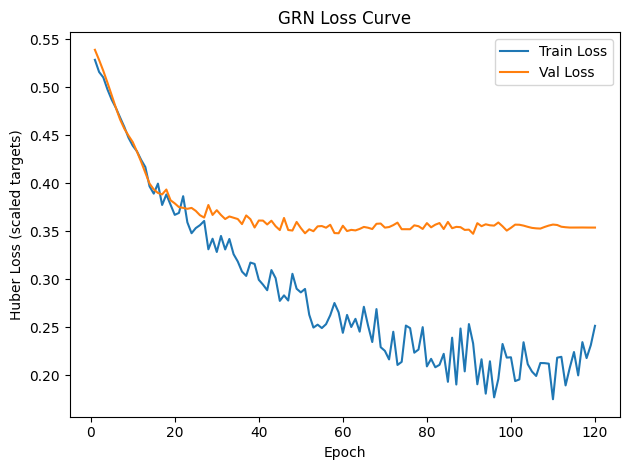

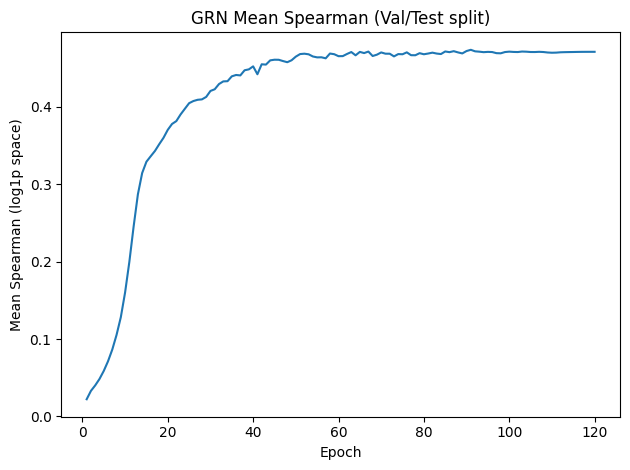

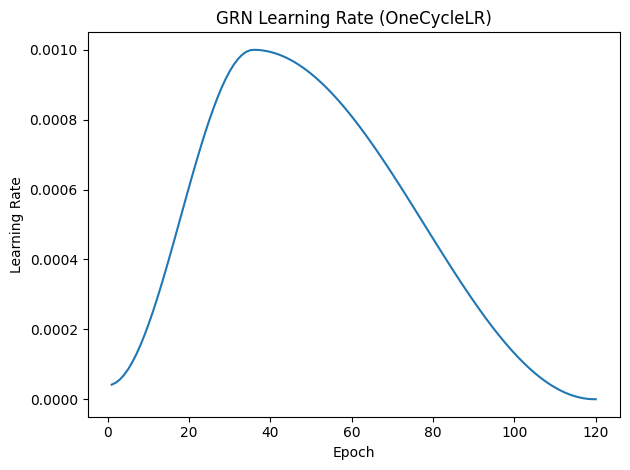

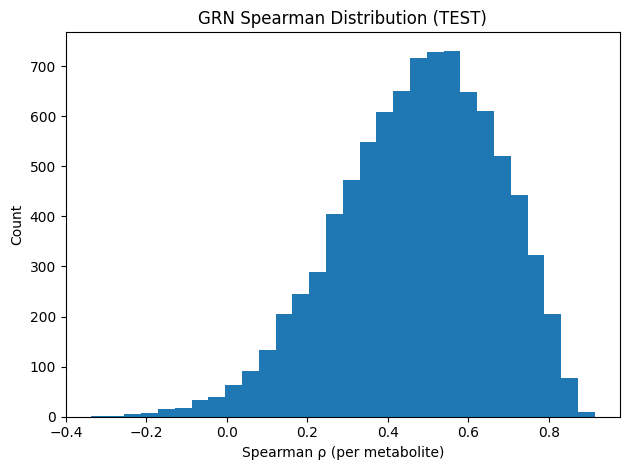

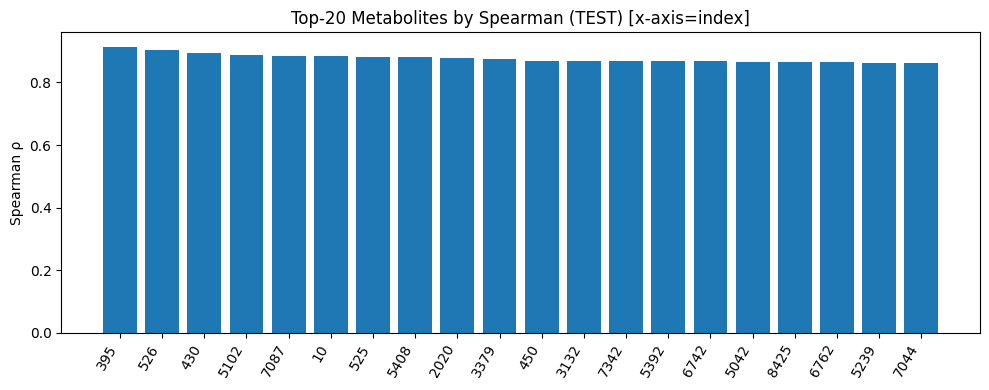

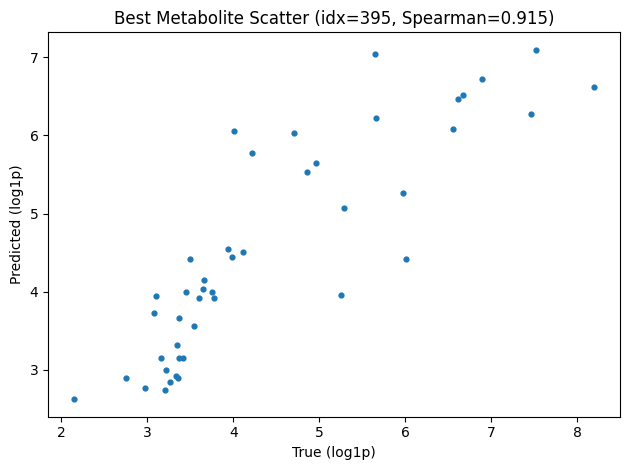

In [12]:
# ============================================================
# Microbiome → Metabolites (GRN baseline) + Figures + Saved outputs
# Adds:
#   - Train/Val loss curve figure
#   - "Accuracy-like" curve: mean Spearman on validation per epoch
#   - Test: Spearman histogram, Top-K bar, best-metabolite scatter
#   - Save: metrics CSV + correlations CSV + run_summary.txt + figs
# ============================================================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings("ignore")

# ==========================================
# 1. CONFIGURATION
# ==========================================




#GLOBAL_SETTINGS = {
#    'datasets': [
 #       r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019",
    #    r"E:\Dr_Tang\Code\WANG_ESRD_2020",
     #   r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020",
    #],#





default_path = Path(r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019")
BASE_PATH = default_path if default_path.exists() else Path("data")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# --- SELECT YOUR ARCHITECTURE HERE ---
# Options: "CNN", "GRN"
MODEL_TYPE = "GRN"

# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 120
MAX_LR = 0.001
PATIENCE = 40
PREVALENCE = 0.05
SEED = 42
DROPOUT = 0.4
MIXUP_ALPHA = 0.2
WEIGHT_DECAY = 0.05

# Output dirs
SAVE_DIR = Path("saved_models")
FIG_DIR = Path("figures")
OUT_DIR = Path("outputs")
SAVE_DIR.mkdir(exist_ok=True, parents=True)
FIG_DIR.mkdir(exist_ok=True, parents=True)
OUT_DIR.mkdir(exist_ok=True, parents=True)

torch.manual_seed(SEED)
np.random.seed(SEED)

# ==========================================
# 2. DATA LOADING
# ==========================================
print("Loading data...")

def read_tsv(path):
    if not path.exists():
        raise FileNotFoundError(f"{path} not found")
    return pd.read_csv(path, sep="\t", index_col=0).astype(float)

species = read_tsv(BASE_PATH / "species.tsv")
mtb     = read_tsv(BASE_PATH / "mtb.tsv")

common = species.index.intersection(mtb.index)
species = species.loc[common]
mtb     = mtb.loc[common]

# Filter by prevalence
species = species.loc[:, (species > 0).mean() > PREVALENCE]
mtb     = mtb.loc[:, (mtb > 0).mean() > 0.05]

print(f"Species: {species.shape[1]} | Metabolites: {mtb.shape[1]}")

X = np.log1p(species.values)
y = np.log1p(mtb.values)

# Train/Test split (keep as your original)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Scaling (RankGauss for Input, Standard for Target)
scaler_x = QuantileTransformer(output_distribution='normal', random_state=SEED,
                               n_quantiles=min(1000, X_train.shape[0]))
X_train = scaler_x.fit_transform(X_train)
X_test  = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled  = scaler_y.transform(y_test)

X_train_t = torch.FloatTensor(X_train).to(DEVICE)
X_test_t  = torch.FloatTensor(X_test).to(DEVICE)
y_train_t = torch.FloatTensor(y_train_scaled).to(DEVICE)
y_test_scaled_t = torch.FloatTensor(y_test_scaled).to(DEVICE)

# Dataloader
loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)

# ==========================================
# 3. DEFINE ARCHITECTURES
# ==========================================
class GatedBlock(nn.Module):
    def __init__(self, dim, dropout):
        super().__init__()
        self.linear1 = nn.Linear(dim, dim * 2)
        self.glu = nn.GLU()
        self.norm = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.linear1(x)
        x = self.glu(x)
        x = self.dropout(x)
        return self.norm(x + residual)

class MicrobiomeGRN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        self.layers = nn.Sequential(
            GatedBlock(hidden_dim, DROPOUT),
            GatedBlock(hidden_dim, DROPOUT),
            GatedBlock(hidden_dim, DROPOUT),
        )
        self.head = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.layers(x)
        return self.head(x)

# Optional CNN stub (kept for completeness)
class MicrobiomeCNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.in_norm = nn.LayerNorm(input_dim)
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=7, padding=3)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=7, padding=3)
        self.drop = nn.Dropout(DROPOUT)
        self.fc = nn.Sequential(
            nn.Linear(64, 256),
            nn.GELU(),
            nn.Dropout(DROPOUT),
            nn.Linear(256, output_dim),
        )

    def forward(self, x):
        x = self.in_norm(x)
        x = x.unsqueeze(1)
        x = torch.nn.functional.gelu(self.conv1(x))
        x = self.drop(x)
        x = torch.nn.functional.gelu(self.conv2(x))
        x = self.drop(x)
        x = torch.nn.functional.gelu(self.conv3(x))
        x = x.mean(dim=-1)
        return self.fc(x)

# ==========================================
# 4. INITIALIZE MODEL
# ==========================================
print(f"\n--- Initializing {MODEL_TYPE} Architecture ---")

if MODEL_TYPE == "CNN":
    model = MicrobiomeCNN(X_train.shape[1], y_train.shape[1]).to(DEVICE)
elif MODEL_TYPE == "GRN":
    model = MicrobiomeGRN(X_train.shape[1], y_train.shape[1]).to(DEVICE)
else:
    raise ValueError("Invalid MODEL_TYPE")

optimizer = optim.AdamW(model.parameters(), lr=MAX_LR, weight_decay=WEIGHT_DECAY)
criterion = nn.HuberLoss(delta=1.0)

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=MAX_LR, epochs=EPOCHS,
    steps_per_epoch=len(X_train_t)//BATCH_SIZE + 1,
    pct_start=0.3
)

print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
CKPT = SAVE_DIR / f"best_model_{MODEL_TYPE}.pth"

# ==========================================
# 5. TRAINING (with history)
# ==========================================
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    index = torch.randperm(x.size(0)).to(DEVICE)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(crit, pred, y_a, y_b, lam):
    return lam * crit(pred, y_a) + (1 - lam) * crit(pred, y_b)

def mean_spearman_on_split(model, X_t, y_true_unscaled):
    """
    Computes mean Spearman across metabolites in log1p space.
    y_true_unscaled should be log1p values (not standardized).
    """
    model.eval()
    with torch.no_grad():
        preds_scaled = model(X_t).cpu().numpy()
    preds = scaler_y.inverse_transform(preds_scaled)
    true  = y_true_unscaled
    rhos = []
    for j in range(true.shape[1]):
        if np.std(preds[:, j]) == 0 or np.std(true[:, j]) == 0:
            rhos.append(0.0)
        else:
            rhos.append(float(spearmanr(preds[:, j], true[:, j])[0]))
    return float(np.mean(rhos))

history = {"epoch": [], "train_loss": [], "val_loss": [], "val_mean_spearman": [], "lr": []}
best_val_loss = float('inf')
best_epoch = 0
bad_epochs = 0

print("Starting Training...")

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0

    for xb, yb in loader:
        optimizer.zero_grad(set_to_none=True)
        mixed_xb, y_a, y_b, lam = mixup_data(xb, yb, MIXUP_ALPHA)
        pred = model(mixed_xb)
        loss = mixup_criterion(criterion, pred, y_a, y_b, lam)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()

    # validation loss (scaled target space)
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_t)
        val_loss = criterion(val_pred, y_test_scaled_t).item()

    # "accuracy-like" metric: mean Spearman on test split (original log1p space)
    # (If you later add a separate val split, compute on val instead)
    val_mean_rho = mean_spearman_on_split(model, X_test_t, y_test)

    lr_now = optimizer.param_groups[0]["lr"]
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss / len(loader))
    history["val_loss"].append(val_loss)
    history["val_mean_spearman"].append(val_mean_rho)
    history["lr"].append(lr_now)

    # checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        bad_epochs = 0
        torch.save(model.state_dict(), CKPT)
    else:
        bad_epochs += 1

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:4d} | Train: {history['train_loss'][-1]:.4f} | Val: {val_loss:.4f} | Valρ: {val_mean_rho:.4f}")

    if bad_epochs >= PATIENCE:
        print(f"Early stop at epoch {epoch} | best epoch {best_epoch} | best val {best_val_loss:.4f}")
        break

# Save history CSV
hist_df = pd.DataFrame(history)
hist_df.to_csv(OUT_DIR / f"training_history_{MODEL_TYPE}.csv", index=False)

# ==========================================
# 6. TRAINING FIGURES
# ==========================================
# Loss curve
plt.figure()
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Huber Loss (scaled targets)")
plt.title(f"{MODEL_TYPE} Loss Curve")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / f"{MODEL_TYPE}_loss_curve.png", dpi=200)

# Mean Spearman curve (accuracy-like)
plt.figure()
plt.plot(history["epoch"], history["val_mean_spearman"])
plt.xlabel("Epoch")
plt.ylabel("Mean Spearman (log1p space)")
plt.title(f"{MODEL_TYPE} Mean Spearman (Val/Test split)")
plt.tight_layout()
plt.savefig(FIG_DIR / f"{MODEL_TYPE}_mean_spearman_curve.png", dpi=200)

# LR curve
plt.figure()
plt.plot(history["epoch"], history["lr"])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title(f"{MODEL_TYPE} Learning Rate (OneCycleLR)")
plt.tight_layout()
plt.savefig(FIG_DIR / f"{MODEL_TYPE}_lr_curve.png", dpi=200)

print(f"\nSaved training figures to: {FIG_DIR.resolve()}")

# ==========================================
# 7. FINAL EVALUATION + SAVED OUTPUTS
# ==========================================
print("\nEvaluating Best Model...")
model.load_state_dict(torch.load(CKPT, map_location=DEVICE))
model.eval()

with torch.no_grad():
    preds_scaled = model(X_test_t).cpu().numpy()

predictions = scaler_y.inverse_transform(preds_scaled)
true_values = y_test

correlations = []
for j in range(true_values.shape[1]):
    if np.std(predictions[:, j]) == 0 or np.std(true_values[:, j]) == 0:
        correlations.append(0.0)
    else:
        correlations.append(float(spearmanr(predictions[:, j], true_values[:, j])[0]))

correlations = np.array(correlations, dtype=float)
mean_rho = float(np.mean(correlations))
well_predicted = int(np.sum(correlations >= 0.3))
best_idx = int(np.argmax(correlations))
best_rho = float(correlations[best_idx])

# Save correlations table
corr_df = pd.DataFrame({
    "metabolite_index": np.arange(len(correlations)),
    "spearman_rho": correlations
}).sort_values("spearman_rho", ascending=False)
corr_df.to_csv(OUT_DIR / f"test_spearman_per_metabolite_{MODEL_TYPE}.csv", index=False)

# Save summary txt
summary_path = OUT_DIR / f"run_summary_{MODEL_TYPE}.txt"
with open(summary_path, "w", encoding="utf-8") as f:
    f.write("FINAL RESULTS\n")
    f.write("="*70 + "\n")
    f.write(f"MODEL_TYPE: {MODEL_TYPE}\n")
    f.write(f"Best epoch (by val loss): {best_epoch}\n")
    f.write(f"Best val loss: {best_val_loss:.6f}\n")
    f.write(f"Average Spearman rho: {mean_rho:.6f}\n")
    f.write(f"Well-predicted (rho >= 0.3): {well_predicted} / {len(correlations)} "
            f"({well_predicted/len(correlations)*100:.2f}%)\n")
    f.write(f"Best metabolite rho: {best_rho:.6f} (index={best_idx})\n")
    f.write("="*70 + "\n")

print("\n" + "="*70)
print(f"FINAL RESULTS - {MODEL_TYPE} ARCHITECTURE")
print("="*70)
print(f"Average Spearman ρ:          {mean_rho:.4f}")
print(f"Well-predicted (ρ ≥ 0.3):    {well_predicted:,} / {len(correlations)} ({well_predicted/len(correlations)*100:.1f}%)")
print(f"Best metabolite:             {best_rho:.4f} (index={best_idx})")
print(f"Saved: history CSV, correlations CSV, summary TXT in {OUT_DIR.resolve()}")
print("="*70)

# ==========================================
# 8. EVALUATION FIGURES
# ==========================================
# Spearman histogram
plt.figure()
plt.hist(correlations, bins=30)
plt.xlabel("Spearman ρ (per metabolite)")
plt.ylabel("Count")
plt.title(f"{MODEL_TYPE} Spearman Distribution (TEST)")
plt.tight_layout()
plt.savefig(FIG_DIR / f"{MODEL_TYPE}_spearman_hist.png", dpi=200)

# Top-K bar plot
K = min(20, len(correlations))
top_idx = np.argsort(-correlations)[:K]
plt.figure(figsize=(10, 4))
plt.bar(np.arange(K), correlations[top_idx])
plt.xticks(np.arange(K), [str(i) for i in top_idx], rotation=60, ha="right")
plt.ylabel("Spearman ρ")
plt.title(f"Top-{K} Metabolites by Spearman (TEST) [x-axis=index]")
plt.tight_layout()
plt.savefig(FIG_DIR / f"{MODEL_TYPE}_topk_spearman.png", dpi=200)

# Best metabolite scatter: Pred vs True
plt.figure()
plt.scatter(true_values[:, best_idx], predictions[:, best_idx], s=12)
plt.xlabel("True (log1p)")
plt.ylabel("Predicted (log1p)")
plt.title(f"Best Metabolite Scatter (idx={best_idx}, Spearman={best_rho:.3f})")
plt.tight_layout()
plt.savefig(FIG_DIR / f"{MODEL_TYPE}_best_metabolite_scatter.png", dpi=200)

print(f"Saved evaluation figures to: {FIG_DIR.resolve()}")


In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import os
import warnings
import copy

warnings.filterwarnings("ignore")

# ==========================================
# 1. CONFIGURATION
# ==========================================
# List of datasets to process sequentially
DATASETS = [
    r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019",
    r"E:\Dr_Tang\Code\WANG_ESRD_2020",
    r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020",
]

# Hyperparameters (Same for all datasets)
CONFIG = {
    'MODEL_TYPE': "GRN",  # "GRN" or "CNN"
    'BATCH_SIZE': 32,
    'EPOCHS': 120,
    'MAX_LR': 0.001,
    'PATIENCE': 40,
    'PREVALENCE': 0.05,
    'SEED': 42,
    'DROPOUT': 0.4,
    'MIXUP_ALPHA': 0.2,
    'WEIGHT_DECAY': 0.05
}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Root directories for outputs
GLOBAL_SAVE_ROOT = Path("multi_dataset_results_GRN")
GLOBAL_SAVE_ROOT.mkdir(exist_ok=True)

# ==========================================
# 2. MODEL ARCHITECTURES
# ==========================================
class GatedBlock(nn.Module):
    def __init__(self, dim, dropout):
        super().__init__()
        self.linear1 = nn.Linear(dim, dim * 2)
        self.glu = nn.GLU()
        self.norm = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.linear1(x)
        x = self.glu(x)
        x = self.dropout(x)
        return self.norm(x + residual)

class MicrobiomeGRN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256, dropout=0.4):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        self.layers = nn.Sequential(
            GatedBlock(hidden_dim, dropout),
            GatedBlock(hidden_dim, dropout),
            GatedBlock(hidden_dim, dropout),
        )
        self.head = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.layers(x)
        return self.head(x)

class MicrobiomeCNN(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.4):
        super().__init__()
        self.in_norm = nn.LayerNorm(input_dim)
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=7, padding=3)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=7, padding=3)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Sequential(
            nn.Linear(64, 256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, output_dim),
        )

    def forward(self, x):
        x = self.in_norm(x)
        x = x.unsqueeze(1)
        x = torch.nn.functional.gelu(self.conv1(x))
        x = self.drop(x)
        x = torch.nn.functional.gelu(self.conv2(x))
        x = self.drop(x)
        x = torch.nn.functional.gelu(self.conv3(x))
        x = x.mean(dim=-1)
        return self.fc(x)

# ==========================================
# 3. TRAINING UTILS
# ==========================================
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    index = torch.randperm(x.size(0)).to(DEVICE)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(crit, pred, y_a, y_b, lam):
    return lam * crit(pred, y_a) + (1 - lam) * crit(pred, y_b)

def mean_spearman_on_split(model, X_t, y_true_unscaled, scaler_y):
    model.eval()
    with torch.no_grad():
        preds_scaled = model(X_t).cpu().numpy()
    preds = scaler_y.inverse_transform(preds_scaled)
    true  = y_true_unscaled
    rhos = []
    for j in range(true.shape[1]):
        if np.std(preds[:, j]) == 0 or np.std(true[:, j]) == 0:
            rhos.append(0.0)
        else:
            rhos.append(float(spearmanr(preds[:, j], true[:, j])[0]))
    return float(np.mean(rhos))

# ==========================================
# 4. SINGLE DATASET PIPELINE
# ==========================================
def process_dataset(dataset_path_str):
    path = Path(dataset_path_str)
    dataset_name = path.name
    
    print(f"\n{'='*60}")
    print(f"PROCESSING: {dataset_name}")
    print(f"{'='*60}")

    # Create specific output folders for this dataset
    SAVE_DIR = GLOBAL_SAVE_ROOT / dataset_name / "saved_models"
    FIG_DIR = GLOBAL_SAVE_ROOT / dataset_name / "figures"
    OUT_DIR = GLOBAL_SAVE_ROOT / dataset_name / "outputs"
    
    SAVE_DIR.mkdir(parents=True, exist_ok=True)
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    OUT_DIR.mkdir(parents=True, exist_ok=True)

    # Set seed for reproducibility per dataset
    torch.manual_seed(CONFIG['SEED'])
    np.random.seed(CONFIG['SEED'])

    # --- Load Data ---
    try:
        species = pd.read_csv(path / "species.tsv", sep="\t", index_col=0).astype(float)
        mtb = pd.read_csv(path / "mtb.tsv", sep="\t", index_col=0).astype(float)
    except FileNotFoundError:
        print(f"!! Error: Files not found in {path}. Skipping.")
        return None

    # Align
    common = species.index.intersection(mtb.index)
    species = species.loc[common]
    mtb = mtb.loc[common]

    # Filter
    species = species.loc[:, (species > 0).mean() > CONFIG['PREVALENCE']]
    mtb = mtb.loc[:, (mtb > 0).mean() > 0.05]

    print(f"Samples: {len(common)} | Species: {species.shape[1]} | Metabolites: {mtb.shape[1]}")

    X = np.log1p(species.values)
    y = np.log1p(mtb.values)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=CONFIG['SEED'])

    # Scaling
    scaler_x = QuantileTransformer(output_distribution='normal', random_state=CONFIG['SEED'], n_quantiles=min(1000, X_train.shape[0]))
    X_train = scaler_x.fit_transform(X_train)
    X_test  = scaler_x.transform(X_test)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled  = scaler_y.transform(y_test)

    X_train_t = torch.FloatTensor(X_train).to(DEVICE)
    X_test_t  = torch.FloatTensor(X_test).to(DEVICE)
    y_train_t = torch.FloatTensor(y_train_scaled).to(DEVICE)
    y_test_scaled_t = torch.FloatTensor(y_test_scaled).to(DEVICE)

    loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=CONFIG['BATCH_SIZE'], shuffle=True)

    # --- Initialize Model ---
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]

    if CONFIG['MODEL_TYPE'] == "CNN":
        model = MicrobiomeCNN(input_dim, output_dim, dropout=CONFIG['DROPOUT']).to(DEVICE)
    else:
        model = MicrobiomeGRN(input_dim, output_dim, dropout=CONFIG['DROPOUT']).to(DEVICE)

    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['MAX_LR'], weight_decay=CONFIG['WEIGHT_DECAY'])
    criterion = nn.HuberLoss(delta=1.0)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CONFIG['MAX_LR'], epochs=CONFIG['EPOCHS'], 
                                              steps_per_epoch=len(loader), pct_start=0.3)

    # --- Training Loop ---
    history = {"epoch": [], "train_loss": [], "val_loss": [], "val_mean_spearman": [], "lr": []}
    best_val_loss = float('inf')
    best_epoch = 0
    bad_epochs = 0
    CKPT = SAVE_DIR / "best_model.pth"

    print("Starting Training...")
    for epoch in range(1, CONFIG['EPOCHS'] + 1):
        model.train()
        train_loss = 0.0
        for xb, yb in loader:
            optimizer.zero_grad()
            mixed_xb, y_a, y_b, lam = mixup_data(xb, yb, CONFIG['MIXUP_ALPHA'])
            pred = model(mixed_xb)
            loss = mixup_criterion(criterion, pred, y_a, y_b, lam)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_test_t)
            val_loss = criterion(val_pred, y_test_scaled_t).item()

        # Calculate metric
        val_mean_rho = mean_spearman_on_split(model, X_test_t, y_test, scaler_y)

        # Logging
        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss / len(loader))
        history["val_loss"].append(val_loss)
        history["val_mean_spearman"].append(val_mean_rho)
        history["lr"].append(optimizer.param_groups[0]["lr"])

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            bad_epochs = 0
            torch.save(model.state_dict(), CKPT)
        else:
            bad_epochs += 1

        if epoch % 20 == 0:
            print(f"Epoch {epoch:3d} | Train: {history['train_loss'][-1]:.4f} | Val: {val_loss:.4f} | Val Rho: {val_mean_rho:.4f}")

        if bad_epochs >= CONFIG['PATIENCE']:
            print(f"Early stop at epoch {epoch}")
            break

    # --- Final Evaluation ---
    print("\nEvaluating Best Model...")
    model.load_state_dict(torch.load(CKPT, map_location=DEVICE))
    model.eval()
    with torch.no_grad():
        preds_scaled = model(X_test_t).cpu().numpy()
    
    predictions = scaler_y.inverse_transform(preds_scaled)
    true_values = y_test

    correlations = []
    for j in range(true_values.shape[1]):
        if np.std(predictions[:, j]) == 0 or np.std(true_values[:, j]) == 0:
            correlations.append(0.0)
        else:
            correlations.append(float(spearmanr(predictions[:, j], true_values[:, j])[0]))

    mean_rho = np.mean(correlations)
    well_pred = sum(r >= 0.3 for r in correlations)
    best_met = max(correlations)

    # --- Save Figures ---
    # Loss Curve
    plt.figure()
    plt.plot(history["epoch"], history["train_loss"], label="Train")
    plt.plot(history["epoch"], history["val_loss"], label="Val")
    plt.title(f"{dataset_name} Loss Curve")
    plt.legend()
    plt.savefig(FIG_DIR / "loss_curve.png")
    plt.close()

    # Spearman Histogram
    plt.figure()
    plt.hist(correlations, bins=30)
    plt.title(f"{dataset_name} Spearman Histogram")
    plt.xlabel("Spearman Rho")
    plt.savefig(FIG_DIR / "spearman_hist.png")
    plt.close()

    # Save Stats
    with open(OUT_DIR / "summary.txt", "w") as f:
        f.write(f"Dataset: {dataset_name}\n")
        f.write(f"Avg Spearman: {mean_rho:.4f}\n")
        f.write(f"Best Metabolite: {best_met:.4f}\n")
        f.write(f"Well Predicted (>0.3): {well_pred}/{len(correlations)}\n")

    print(f">> DONE: Avg Rho={mean_rho:.4f} | Best={best_met:.4f}")
    
    return {
        'Dataset': dataset_name,
        'Samples': len(common),
        'Avg_Spearman': mean_rho,
        'Best_Metabolite': best_met,
        'Well_Predicted_Pct': well_pred / len(correlations)
    }

# ==========================================
# 5. MAIN EXECUTION LOOP
# ==========================================
final_results = []

print(f"Starting Multi-Dataset Run for Model: {CONFIG['MODEL_TYPE']}")

for path in DATASETS:
    res = process_dataset(path)
    if res:
        final_results.append(res)

# Summary Table
print("\n" + "="*60)
print("FINAL MULTI-DATASET SUMMARY")
print("="*60)
df_final = pd.DataFrame(final_results)
print(df_final)

# Save aggregate
df_final.to_csv(GLOBAL_SAVE_ROOT / "all_datasets_summary.csv", index=False)
print(f"\nAll results saved to {GLOBAL_SAVE_ROOT}")

Using device: cuda
Starting Multi-Dataset Run for Model: GRN

PROCESSING: FRANZOSA_IBD_2019
Samples: 220 | Species: 25768 | Metabolites: 8848
Starting Training...
Epoch  20 | Train: 0.3669 | Val: 0.3789 | Val Rho: 0.3704
Epoch  40 | Train: 0.2993 | Val: 0.3610 | Val Rho: 0.4524
Epoch  60 | Train: 0.2441 | Val: 0.3556 | Val Rho: 0.4656
Epoch  80 | Train: 0.2091 | Val: 0.3584 | Val Rho: 0.4680
Epoch 100 | Train: 0.2186 | Val: 0.3535 | Val Rho: 0.4714
Epoch 120 | Train: 0.2514 | Val: 0.3537 | Val Rho: 0.4712

Evaluating Best Model...
>> DONE: Avg Rho=0.4738 | Best=0.9146

PROCESSING: WANG_ESRD_2020
Samples: 287 | Species: 30684 | Metabolites: 276
Starting Training...
Epoch  20 | Train: 0.2425 | Val: 0.3243 | Val Rho: 0.2664
Epoch  40 | Train: 0.1793 | Val: 0.3326 | Val Rho: 0.2922
Epoch  60 | Train: 0.1491 | Val: 0.3248 | Val Rho: 0.2928
Epoch  80 | Train: 0.1393 | Val: 0.3201 | Val Rho: 0.2879
Epoch 100 | Train: 0.1174 | Val: 0.3214 | Val Rho: 0.2880
Epoch 120 | Train: 0.1071 | Val: 0.32

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import spearmanr
import itertools
import gc
import warnings

warnings.filterwarnings("ignore")

# ==========================================
# 1. SETUP & PATHS
# ==========================================
DATASETS = [
    r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019",
    r"E:\Dr_Tang\Code\WANG_ESRD_2020",
    r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020",
]

OUTPUT_ROOT = Path("grid_search_results_GRN")
OUTPUT_ROOT.mkdir(exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ==========================================
# 2. GRID SEARCH SPACE
# ==========================================
# Define the parameters you want to sweep here
GRID_SEARCH_SPACE = {
    # Architecture Params
    'hidden_dim':   [256, 512],      # Embedding Dimension
    'depth':        [2, 3, 4],       # Number of Layers
    'dropout':      [0.3, 0.5],      # Dropout Values
    
    # Training Params
    'batch_size':   [32, 64],
    'lr':           [0.0005, 0.001], # Learning Rate
    'weight_decay': [0.05, 0.2]      # Weight Decay
}

# Fixed parameters (Constants)
CONSTANTS = {
    'epochs': 100,           # Enough to see convergence
    'patience': 25,          # Early stopping
    'prevalence': 0.05,
    'mixup_alpha': 0.2,
    'seed': 42
}

# ==========================================
# 3. MODEL ARCHITECTURE (GRN)
# ==========================================
class GatedBlock(nn.Module):
    def __init__(self, dim, dropout):
        super().__init__()
        self.linear1 = nn.Linear(dim, dim * 2)
        self.glu = nn.GLU()
        self.norm = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.linear1(x)
        x = self.glu(x)
        x = self.dropout(x)
        return self.norm(x + residual)

class MicrobiomeGRN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256, depth=3, dropout=0.4):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        
        # Dynamically create layers based on depth parameter
        self.layers = nn.ModuleList([
            GatedBlock(hidden_dim, dropout) for _ in range(depth)
        ])
        
        self.head = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        return self.head(x)

# ==========================================
# 4. TRAINING UTILS
# ==========================================
def mixup_data(x, y, alpha=0.2):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1.0
    index = torch.randperm(x.size(0)).to(DEVICE)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(crit, pred, y_a, y_b, lam):
    return lam * crit(pred, y_a) + (1 - lam) * crit(pred, y_b)

def train_single_run(params, data, input_dim, output_dim):
    """
    Runs one training session with specific parameters.
    Returns: Best Validation Spearman Correlation.
    """
    # Set Seed
    torch.manual_seed(CONSTANTS['seed'])
    np.random.seed(CONSTANTS['seed'])
    
    # Initialize Model
    model = MicrobiomeGRN(
        input_dim, 
        output_dim, 
        hidden_dim=params['hidden_dim'], 
        depth=params['depth'], 
        dropout=params['dropout']
    ).to(DEVICE)
    
    optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    criterion = nn.HuberLoss(delta=1.0)
    
    train_loader = DataLoader(data['train'], batch_size=params['batch_size'], shuffle=True)
    
    # Scheduler
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=params['lr'], 
        epochs=CONSTANTS['epochs'],
        steps_per_epoch=len(train_loader), 
        pct_start=0.3
    )
    
    best_val_rho = -1.0
    patience_counter = 0
    
    # Training Loop
    for epoch in range(CONSTANTS['epochs']):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            mixed_xb, y_a, y_b, lam = mixup_data(xb, yb, CONSTANTS['mixup_alpha'])
            pred = model(mixed_xb)
            loss = mixup_criterion(criterion, pred, y_a, y_b, lam)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            
        # Evaluation
        model.eval()
        with torch.no_grad():
            preds_scaled = model(data['test_X']).cpu().numpy()
            
        # Inverse Transform & Calc Spearman
        preds = data['scaler_y'].inverse_transform(preds_scaled)
        
        # Calculate Mean Spearman
        # (Optimization: We calculate it every epoch to use it for Early Stopping)
        rhos = []
        for i in range(preds.shape[1]):
            if np.std(preds[:, i]) == 0: r = 0
            else: r, _ = spearmanr(preds[:, i], data['test_y_raw'][:, i])
            rhos.append(r)
        
        current_rho = np.nanmean(rhos)
        
        if current_rho > best_val_rho:
            best_val_rho = current_rho
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= CONSTANTS['patience']:
            break
            
    # Cleanup
    del model
    del optimizer
    torch.cuda.empty_cache()
    
    return best_val_rho

# ==========================================
# 5. DATA LOADING HELPER
# ==========================================
def prepare_data(dataset_path):
    path = Path(dataset_path)
    try:
        species = pd.read_csv(path / "species.tsv", sep="\t", index_col=0).astype(float)
        mtb = pd.read_csv(path / "mtb.tsv", sep="\t", index_col=0).astype(float)
    except FileNotFoundError:
        return None

    common = species.index.intersection(mtb.index)
    species = species.loc[common]
    mtb = mtb.loc[common]

    # Filter
    species = species.loc[:, (species > 0).mean() > CONSTANTS['prevalence']]
    mtb = mtb.loc[:, (mtb > 0).mean() > 0.05]

    X = np.log1p(species.values)
    y = np.log1p(mtb.values)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=CONSTANTS['seed'])

    # Scaling
    scaler_x = QuantileTransformer(output_distribution='normal', random_state=CONSTANTS['seed'])
    X_train = scaler_x.fit_transform(X_train)
    X_test = scaler_x.transform(X_test)

    scaler_y = StandardScaler()
    y_train = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    return {
        'train': TensorDataset(torch.FloatTensor(X_train).to(DEVICE), torch.FloatTensor(y_train).to(DEVICE)),
        'test_X': torch.FloatTensor(X_test).to(DEVICE),
        'test_y_raw': y_test,
        'scaler_y': scaler_y,
        'input_dim': X_train.shape[1],
        'output_dim': y_train.shape[1]
    }

# ==========================================
# 6. MAIN GRID SEARCH LOOP
# ==========================================
def run_grid_search():
    # Create all combinations of parameters
    keys, values = zip(*GRID_SEARCH_SPACE.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    print(f"Total Configurations to Test: {len(param_combinations)}")
    
    for dataset_path in DATASETS:
        dataset_name = Path(dataset_path).name
        print(f"\n{'='*60}")
        print(f"PROCESSING DATASET: {dataset_name}")
        print(f"{'='*60}")
        
        # Prepare Data
        data = prepare_data(dataset_path)
        if data is None:
            print(f"Skipping {dataset_name} (Files not found)")
            continue
            
        dataset_results = []
        
        # Loop through combinations
        for i, params in enumerate(param_combinations):
            print(f"   [{i+1}/{len(param_combinations)}] Params: {params} ... ", end="", flush=True)
            
            try:
                score = train_single_run(params, data, data['input_dim'], data['output_dim'])
                print(f"Score: {score:.4f}")
                
                # Record Result
                record = params.copy()
                record['dataset'] = dataset_name
                record['avg_spearman'] = score
                dataset_results.append(record)
                
            except Exception as e:
                print(f"Failed! ({e})")
        
        # Save Results for this Dataset
        df = pd.DataFrame(dataset_results)
        save_path = OUTPUT_ROOT / f"grid_results_{dataset_name}.csv"
        df.to_csv(save_path, index=False)
        print(f"   >> Results saved to {save_path}")
        
        # Identify Best Config
        if not df.empty:
            best_row = df.loc[df['avg_spearman'].idxmax()]
            print(f"   >> BEST CONFIG FOR {dataset_name}:")
            print(f"      Score: {best_row['avg_spearman']:.4f}")
            print(f"      Params: {best_row.to_dict()}")
            
        # Clear Memory
        del data
        gc.collect()
        torch.cuda.empty_cache()

if __name__ == "__main__":
    run_grid_search()

Using device: cuda
Total Configurations to Test: 96

PROCESSING DATASET: FRANZOSA_IBD_2019
   [1/96] Params: {'hidden_dim': 256, 'depth': 2, 'dropout': 0.3, 'batch_size': 32, 'lr': 0.0005, 'weight_decay': 0.05} ... Score: 0.4733
   [2/96] Params: {'hidden_dim': 256, 'depth': 2, 'dropout': 0.3, 'batch_size': 32, 'lr': 0.0005, 'weight_decay': 0.2} ... Score: 0.4735
   [3/96] Params: {'hidden_dim': 256, 'depth': 2, 'dropout': 0.3, 'batch_size': 32, 'lr': 0.001, 'weight_decay': 0.05} ... Score: 0.4765
   [4/96] Params: {'hidden_dim': 256, 'depth': 2, 'dropout': 0.3, 'batch_size': 32, 'lr': 0.001, 'weight_decay': 0.2} ... Score: 0.4766
   [5/96] Params: {'hidden_dim': 256, 'depth': 2, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.0005, 'weight_decay': 0.05} ... Score: 0.4632
   [6/96] Params: {'hidden_dim': 256, 'depth': 2, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.0005, 'weight_decay': 0.2} ... Score: 0.4634
   [7/96] Params: {'hidden_dim': 256, 'depth': 2, 'dropout': 0.3, 'batch_size': 64, 'l